In [2]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
# Set BASE_PATH to the base directory where all the model data will be stored
BASE_PATH = os.path.expanduser('~/models')

## Data model overview

### Input data sources

#### model.csv

Contains one row per model. A model can be identified by the combination of batch + patho_code + task_code

A batch is identified by the combination of cap + split + is_lazy.

#### input/train.csv, input/test.csv (in each model)

One table per model. Used to calculate input size and % of positives

#### test/performance_table.csv (in each model)

One table per model. They contain one row per submodel, with performance statistics

### Level 1 - data marts

#### submodel_results

One row per submodel, with performance statistics

#### model_results

One row per model. It takes from submodel_results the row for the ensemble model

#### model_details

One row per model, with some calculated columns

### Level 2 - report data

#### report_model

One row per model. It contains all the columns that may be relevant for reporting

## Read model master - Initial filter

In [3]:
# Models master table
df_model = pd.read_csv('../model_metadata/model.csv')
print('\nShape:', df_model.shape)
# print()
# print(df_model.cap.value_counts())
# print()
# print(df_model.split.value_counts())
# print()
# print(df_model.is_lazy.value_counts())


Shape: (182, 5)


In [4]:
# Filter models master table
# We will work only with a given cap, e.g. 3k or full
df_model = df_model[(df_model.cap=='full')]
print('\nShape:', df_model.shape)


Shape: (182, 5)


## Gather model results

Build tables submodel_results, model_results, model_details

In [5]:
def get_codes(cap, split, is_lazy):
    """For given batch (cap + split + is_lazy), form the path where it is stored"""
    
    if cap in ('3k', '10k', 'full'):
        cap_code = cap
    else:
        raise ValueError('Invalid value of column cap.')
        
    if split=='random':
        split_code = 'rnd'
    elif split=='scaffold':
        split_code = 'scf'
    elif split=='similarity':
        split_code = 'sim'
    elif split=='default':
        split_code = 'def'
    else:
        raise ValueError('Invalid value of column split.')
        
    if is_lazy=='lazy':
        is_lazy_code = '_lazy'
    else:
        is_lazy_code = ''
        
    return cap_code, split_code, is_lazy_code

In [6]:
def get_model_dir(base_dir, cap, split, is_lazy, patho_code, task_code):
    # Example desired output:
    # /home/marcos/models_lazy_10k_scf/paeruginosa/paeruginosa_organism_mic
    cap_code, split_code, is_lazy_code = get_codes(cap, split, is_lazy)
    batch_dir = 'models' + is_lazy_code + '_' + cap_code + '_' + split_code
    patho_task_dir = patho_code + '_' + task_code
    model_dir = os.path.join(base_dir, batch_dir, patho_code, patho_task_dir)
    
    return model_dir

In [7]:
def compile_model_input_size(df_model_list, base_dir):
    """Given a list of models, obtain information on the input data (size and percent of positives)"""
    
    df_output = df_model_list.copy()
    df_output['train_size'] = 0
    df_output['test_size'] = 0
    df_output['train_pct_pos'] = 0
    df_output['test_pct_pos'] = 0
    for i, row in df_model_list.iterrows():
        # dir_input will contain input data for current model
        model_dir = get_model_dir(base_dir, row.cap, row.split, row.is_lazy, row.patho_code, row.task_code)        
        dir_input = os.path.join(model_dir, 'input')
        filename_train = os.path.join(dir_input, 'train.csv')
        filename_test = os.path.join(dir_input, 'test.csv')
        
        if not os.path.isfile(filename_train):
            print('WARNING - Model train dataset does not exist:', filename_train)
        else:
            # Count rows and percent of positives
            df_train = pd.read_csv(filename_train)
            df_test = pd.read_csv(filename_test)
            num_rows_train = len(df_train)
            num_pos_train = len(df_train[df_train.activity==1])
            num_rows_test = len(df_test)
            num_pos_test = len(df_test[df_test.activity==1])
            # Store info in output dataframe
            df_output.loc[i, 'train_size'] = num_rows_train
            df_output.loc[i, 'train_pct_pos'] = num_pos_train / num_rows_train
            df_output.loc[i, 'test_size'] = num_rows_test
            df_output.loc[i, 'test_pct_pos'] = num_pos_test / num_rows_test
            
    return df_output


In [11]:
# Get the size and pct of positives
df_model_details = compile_model_input_size(
    df_model_list=df_model,
    base_dir=BASE_PATH)

print('\nShape:', df_model_details.shape)
df_model_details.head()


Shape: (182, 9)


,cap,split,is_lazy,patho_code,task_code,train_size,test_size,train_pct_pos,test_pct_pos
0,full,similarity,lazy,efaecium,organism_anytype,4225,1244,0.338225,0.341640
1,full,similarity,lazy,efaecium,organism_anytype_hc,4225,1244,0.158580,0.192926
2,full,similarity,lazy,efaecium,organism_mic,3892,1128,0.347379,0.349291
3,full,similarity,lazy,efaecium,organism_mic_hc,3892,1128,0.160586,0.191489
4,full,similarity,lazy,efaecium,organism_inhibition,87,23,0.344828,0.434783


In [12]:
def compile_similarity_train_test(df_model_list, base_dir):
    """Given a list of models, obtain for each model a measure of similarity between the train and test set"""
    
        
    df_result = df_model_list.copy()
    df_result['similarity_test_train1'] = 0
    df_result['similarity_test_train5'] = 0
    for i, row in df_model_list.iterrows():
        # dir_output will contain the assesment results for current model
        model_dir = get_model_dir(base_dir, row.cap, row.split, row.is_lazy, row.patho_code, row.task_code)        
        dir_output = os.path.join(model_dir, 'test')
        filename_output_table = os.path.join(dir_output, 'output_table.csv')
        
        if not os.path.isfile(filename_output_table):
            print('WARNING - Model output file does not exist:', filename_output_table)
        else:
            # Count rows and percent of positives
            df = pd.read_csv(filename_output_table)
            df_result.loc[i, 'similarity_test_train1'] = df.sim_0.mean()
            df['mean_5_sim'] = (df.sim_0 + df.sim_1 + df.sim_2 + df.sim_3 + df.sim_4) / 5
            df_result.loc[i, 'similarity_test_train5'] = df.mean_5_sim.mean()
                        
    return df_result


In [15]:
# Get the measures of similarity train-test
df_model_details = compile_similarity_train_test(
    df_model_list=df_model_details,
    base_dir=BASE_PATH)

print('\nShape:', df_model_details.shape)
df_model_details.head()

WARNING - Model output file does not exist: /home/marcos/models/models_lazy_full_scf/kpneumoniae/kpneumoniae_organism_ic50/test/output_table.csv
WARNING - Model output file does not exist: /home/marcos/models/models_lazy_full_scf/kpneumoniae/kpneumoniae_organism_ic50_hc/test/output_table.csv
WARNING - Model output file does not exist: /home/marcos/models/models_full_scf/saureus/saureus_organism_anytype/test/output_table.csv
WARNING - Model output file does not exist: /home/marcos/models/models_full_scf/saureus/saureus_organism_anytype_hc/test/output_table.csv

Shape: (182, 11)


,cap,split,is_lazy,patho_code,task_code,train_size,test_size,train_pct_pos,test_pct_pos,similarity_test_train1,similarity_test_train5
0,full,similarity,lazy,efaecium,organism_anytype,4225,1244,0.338225,0.341640,0.692873,0.624354
1,full,similarity,lazy,efaecium,organism_anytype_hc,4225,1244,0.158580,0.192926,0.692873,0.624354
2,full,similarity,lazy,efaecium,organism_mic,3892,1128,0.347379,0.349291,0.703163,0.635709
3,full,similarity,lazy,efaecium,organism_mic_hc,3892,1128,0.160586,0.191489,0.703163,0.635709
4,full,similarity,lazy,efaecium,organism_inhibition,87,23,0.344828,0.434783,0.491802,0.409840


In [16]:
def append_to_df_to_df(df_add, df_base):
    if df_base is None:  # Create df if empty
        df_base = df_add
    else:
        df_base = pd.concat([df_base, df_add], ignore_index=True)

    return df_base.copy()

def compile_model_results(df_model_list, base_dir):
    # Example directory with model results:
    # /home/marcos/models_lazy_10k_scf/paeruginosa/paeruginosa_organism_mic
    
    df_output_all = None
    for i, row in df_model_list.iterrows():
        # dir_output will contain the assesment results for current model
        model_dir = get_model_dir(base_dir, row.cap, row.split, row.is_lazy, row.patho_code, row.task_code)        
        dir_output = os.path.join(model_dir, 'test')
        filename_performance_table = os.path.join(dir_output, 'performance_table.csv')
        if not os.path.isfile(filename_performance_table):
            print('WARNING - Model output file does not exist:', filename_performance_table)
        else:
            df_add = pd.read_csv(filename_performance_table)
            # Add columns to identify model
            df_add['cap'] = row['cap']
            df_add['split'] = row['split']
            df_add['is_lazy'] = row['is_lazy']
            df_add['patho_code'] = row['patho_code']
            df_add['task_code'] = row['task_code']
            # Append to output file
            df_output_all = append_to_df_to_df(df_base=df_output_all, df_add=df_add)
            
    # Drop and rename columns
    df_output_all.drop(columns=['num_train', 'num_train_0', 'num_train_1',
                                'num_test', 'num_test_0', 'num_test_1'], inplace=True)
    df_output_all.rename(columns={'model':'submodel'}, inplace=True)
    
    return df_output_all


In [18]:
df_submodel_results = compile_model_results(
    df_model_list=df_model_details,
    base_dir=BASE_PATH)
print('\nShape:', df_submodel_results.shape)

WARNING - Model output file does not exist: /home/marcos/models/models_lazy_full_scf/kpneumoniae/kpneumoniae_organism_ic50/test/performance_table.csv
WARNING - Model output file does not exist: /home/marcos/models/models_lazy_full_scf/kpneumoniae/kpneumoniae_organism_ic50_hc/test/performance_table.csv
WARNING - Model output file does not exist: /home/marcos/models/models_full_scf/saureus/saureus_organism_anytype/test/performance_table.csv
WARNING - Model output file does not exist: /home/marcos/models/models_full_scf/saureus/saureus_organism_anytype_hc/test/performance_table.csv

Shape: (802, 24)


In [19]:
df_submodel_results.head()

,submodel,auroc,aupr,cutoff,tp,tn,fp,fn,accuracy,balanced_accuracy,...,precision_at_1,precision_at_5,precision_at_10,precision_at_50,precision_at_100,cap,split,is_lazy,patho_code,task_code
0,pooled,0.873807,0.790686,0.45,272,729,90,153,0.804662,0.765055,...,1.0,1.0,1.0,0.98,0.93,full,similarity,lazy,efaecium,organism_anytype
1,classic,0.824335,0.729152,0.45,254,714,105,171,0.778135,0.734721,...,1.0,1.0,1.0,0.96,0.89,full,similarity,lazy,efaecium,organism_anytype
2,fingerprint,0.882087,0.802147,0.40,296,719,100,129,0.815916,0.787185,...,1.0,1.0,1.0,0.94,0.94,full,similarity,lazy,efaecium,organism_anytype
3,pooled,0.889199,0.717377,0.50,177,885,119,63,0.853698,0.809487,...,1.0,0.6,0.6,0.76,0.66,full,similarity,lazy,efaecium,organism_anytype_hc
4,classic,0.903418,0.734212,0.40,138,938,66,102,0.864952,0.754631,...,1.0,1.0,1.0,0.92,0.88,full,similarity,lazy,efaecium,organism_anytype_hc


In [20]:
# Model_results contains results of the ensemble (pooled) model, not on each sub-model
df_model_results = df_submodel_results[df_submodel_results.submodel=='pooled'].copy()

In [21]:
df_model_results.head()

,submodel,auroc,aupr,cutoff,tp,tn,fp,fn,accuracy,balanced_accuracy,...,precision_at_1,precision_at_5,precision_at_10,precision_at_50,precision_at_100,cap,split,is_lazy,patho_code,task_code
0,pooled,0.873807,0.790686,0.45,272,729,90,153,0.804662,0.765055,...,1.0,1.0,1.0,0.980000,0.930000,full,similarity,lazy,efaecium,organism_anytype
3,pooled,0.889199,0.717377,0.50,177,885,119,63,0.853698,0.809487,...,1.0,0.6,0.6,0.760000,0.660000,full,similarity,lazy,efaecium,organism_anytype_hc
6,pooled,0.867555,0.788967,0.45,258,651,83,136,0.805851,0.770872,...,1.0,1.0,1.0,0.940000,0.930000,full,similarity,lazy,efaecium,organism_mic
9,pooled,0.888544,0.721210,0.30,172,783,129,44,0.846631,0.827424,...,1.0,1.0,0.8,0.680000,0.650000,full,similarity,lazy,efaecium,organism_mic_hc
12,pooled,0.776923,0.581235,0.45,8,10,3,2,0.782609,0.784615,...,0.0,0.6,0.7,0.434783,0.434783,full,similarity,lazy,efaecium,organism_inhibition


## Report data

Generate table report_model

Function generate_pivot_table to generate tabular reports

In [22]:
id_report_model = ['cap', 'split', 'is_lazy', 'patho_code', 'task_code']

In [23]:
# For each model, get the best submodel

df_temp_submodel_best = df_submodel_results[df_submodel_results.submodel!='pooled']\
        .sort_values(by=id_report_model + ['auroc'])\
        .groupby(id_report_model).last()[['submodel', 'auroc']]\
        .rename(columns={'submodel':'best_submodel',
                         'auroc':'best_submodel_auroc'})\
        .reset_index()

df_temp_submodel_best.head()

,cap,split,is_lazy,patho_code,task_code,best_submodel,best_submodel_auroc
0,full,scaffold,lazy,abaumannii,organism_anytype,classic,0.967546
1,full,scaffold,lazy,abaumannii,organism_anytype_hc,fingerprint,0.957142
2,full,scaffold,lazy,abaumannii,organism_inhibition,fingerprint,0.930941
3,full,scaffold,lazy,abaumannii,organism_mic,classic,0.895481
4,full,scaffold,lazy,abaumannii,organism_mic_hc,classic,0.902615


In [24]:
# Table report_model
# This table combines all relevant variables required for reporting 
# at model level (one row per model)
# The base is a merge of model_details and model_results. Then some calculated columns are added:
# - best_submodel: Submodel with the highest auroc
# - best_submodel_auroc: Auroc of best submodel
# - organism_protein: Indicates if the activity variable refers to targeting organism or protein

print('df_model_details shape:', df_model_details.shape)

# Merge model_details and model_results
df_report_model = df_model_details.merge(df_model_results, how='inner',
                                        on=id_report_model)
print('df_report_model shape:', df_report_model.shape)

# Add (left join) the information on the best submodel
df_report_model = df_report_model.merge(df_temp_submodel_best, how='left',
                                       on=id_report_model)
print('df_report_model shape:', df_report_model.shape)

# Calculated columns to facilitate reporting
df_report_model['organism_protein'] = df_report_model.task_code.apply(lambda x: 'protein' if x.startswith('protein') else 'organism')

print('df_report_model shape:', df_report_model.shape)


df_model_details shape: (182, 11)
df_report_model shape: (178, 30)
df_report_model shape: (178, 32)
df_report_model shape: (178, 33)


In [25]:
df_report_model.head()

,cap,split,is_lazy,patho_code,task_code,train_size,test_size,train_pct_pos,test_pct_pos,similarity_test_train1,...,f1_score,mcc,precision_at_1,precision_at_5,precision_at_10,precision_at_50,precision_at_100,best_submodel,best_submodel_auroc,organism_protein
0,full,similarity,lazy,efaecium,organism_anytype,4225,1244,0.338225,0.341640,0.692873,...,0.691233,0.553495,1.0,1.0,1.0,0.980000,0.930000,fingerprint,0.882087,organism
1,full,similarity,lazy,efaecium,organism_anytype_hc,4225,1244,0.158580,0.192926,0.692873,...,0.660448,0.573581,1.0,0.6,0.6,0.760000,0.660000,classic,0.903418,organism
2,full,similarity,lazy,efaecium,organism_mic,3892,1128,0.347379,0.349291,0.703163,...,0.702041,0.562374,1.0,1.0,1.0,0.940000,0.930000,fingerprint,0.877853,organism
3,full,similarity,lazy,efaecium,organism_mic_hc,3892,1128,0.160586,0.191489,0.703163,...,0.665377,0.582545,1.0,1.0,0.8,0.680000,0.650000,fingerprint,0.902001,organism
4,full,similarity,lazy,efaecium,organism_inhibition,87,23,0.344828,0.434783,0.491802,...,0.761905,0.564902,0.0,0.6,0.7,0.434783,0.434783,classic,0.815385,organism


In [19]:
# Export table if required
# df_report_model.to_csv('report_model.csv', index=False)

In [26]:
def generate_pivot_table(df, vars_group, vars_pivot, var_value):
    """Generate pivot table using the indicated variables"""
    
    df1 = df[vars_group + vars_pivot + [var_value]]
    table = pd.pivot_table(df1, values=var_value, index=vars_group, columns=vars_pivot,
                           aggfunc=np.sum).reset_index()
    table.reset_index()
    table.rename_axis(None, axis=1, inplace=True)
    return table

# Reports

### Compare auroc between split criteria

In [27]:
# Compare differences by split
generate_pivot_table(
    df=df_model_results[df_model_results.is_lazy=='zairachem'],
    vars_group=['cap', 'is_lazy', 'patho_code', 'task_code'],
    vars_pivot=['split'],
    var_value='auroc')

,cap,is_lazy,patho_code,task_code,scaffold,similarity
0,full,zairachem,saureus,organism_anytype,NaN,0.861400
1,full,zairachem,saureus,organism_anytype_hc,NaN,0.879261
2,full,zairachem,saureus,organism_assay_top1,0.956097,0.934835
3,full,zairachem,saureus,organism_assay_top1_hc,0.977822,0.900711
4,full,zairachem,saureus,organism_ic50,0.846830,0.868657
5,full,zairachem,saureus,organism_ic50_hc,0.907418,0.792102
6,full,zairachem,saureus,organism_inhibition,0.818574,0.954027
7,full,zairachem,saureus,organism_inhibition_hc,0.843040,0.941108
8,full,zairachem,saureus,organism_iz,0.730062,0.837530
9,full,zairachem,saureus,organism_iz_hc,0.714004,0.848446


### Difference in auroc zairachem - lazy

count    40.000000
mean      0.030048
std       0.048005
min      -0.049579
25%       0.003806
50%       0.020993
75%       0.043783
max       0.247984
Name: zairachem_improvement, dtype: float64


[Text(0.5, 1.0, 'Difference in auroc zairachem - lazy')]

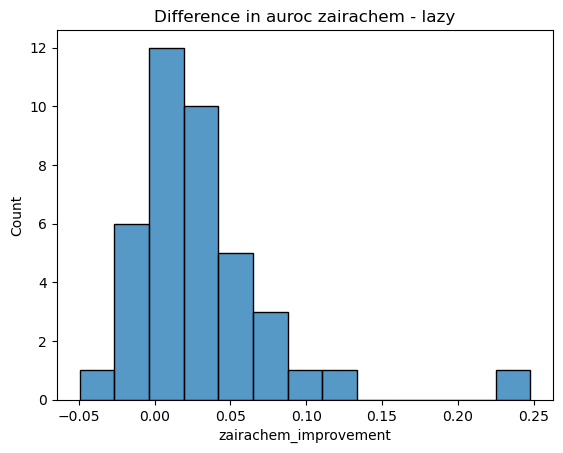

In [28]:
# Within pathogen saureus, for each task and split:
# Compare results of lazy vs zairachem models
df_tmp = generate_pivot_table(
    df=df_model_results[df_model_results.patho_code=='saureus'],
    vars_group=['cap', 'patho_code', 'task_code', 'split'],
    vars_pivot=['is_lazy'],
    var_value='auroc')
df_tmp['zairachem_improvement'] = df_tmp.zairachem - df_tmp.lazy
print(df_tmp.zairachem_improvement.describe())
sns.histplot(data=df_tmp, x='zairachem_improvement').set(title='Difference in auroc zairachem - lazy')

[Text(0.5, 1.0, 'auroc zairachem vs lazy')]

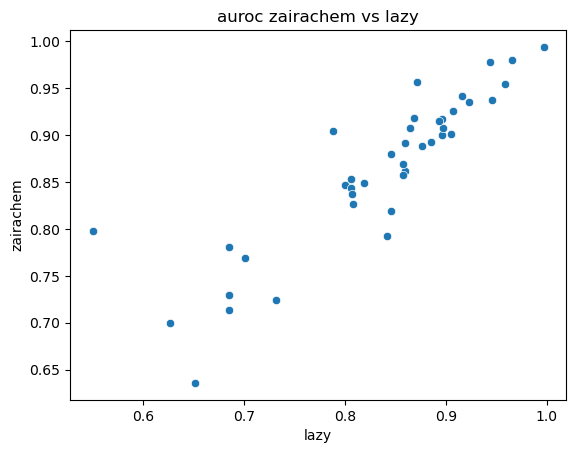

In [29]:
sns.scatterplot(data=df_tmp, x='lazy', y='zairachem').set(title='auroc zairachem vs lazy')

In [30]:
df_tmp.groupby('split').zairachem_improvement.mean()

split
scaffold      0.047628
similarity    0.014142
Name: zairachem_improvement, dtype: float64

### Values of auroc zairachem vs lazy

Text(0.5, 0.98, 'Values of auroc zairachem vs lazy (s. aureus)')

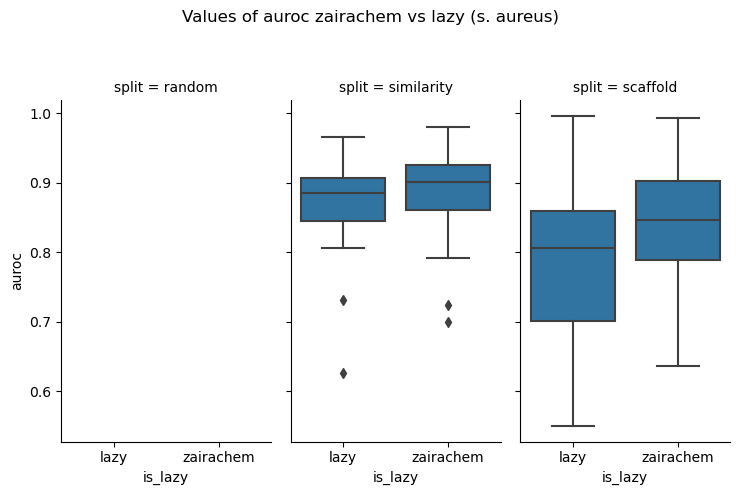

In [31]:
# NOTE: If we want to have data with the random split, we need to change the initial filter into cap='3k'
g = sns.FacetGrid(df_model_results[df_model_results.patho_code=='saureus'], col="split", col_order=['random', 'similarity', 'scaffold'],
                  height=5, aspect=.5)
g = g.map(sns.boxplot, "is_lazy", "auroc", order=["lazy", "zairachem"])
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Values of auroc zairachem vs lazy (s. aureus)')

### Box plots

### auroc by split - Here we use the cap 3k data

[Text(0.5, 1.0, 'auroc by split')]

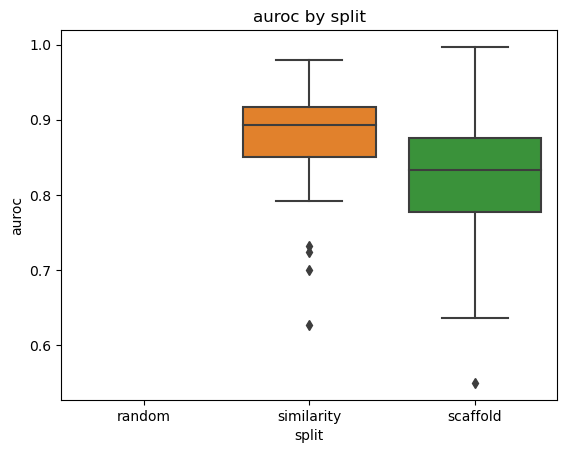

In [32]:
# NOTE: If we want to have data with the random split, we need to change the initial filter into cap='3k'
sns.boxplot(data=df_model_results[df_model_results.patho_code=='saureus'], x='split', y='auroc',
           order=['random', 'similarity', 'scaffold']).set(title='auroc by split')


### auroc by organism-protein

[Text(0.5, 1.0, 'auroc by organism-protein')]

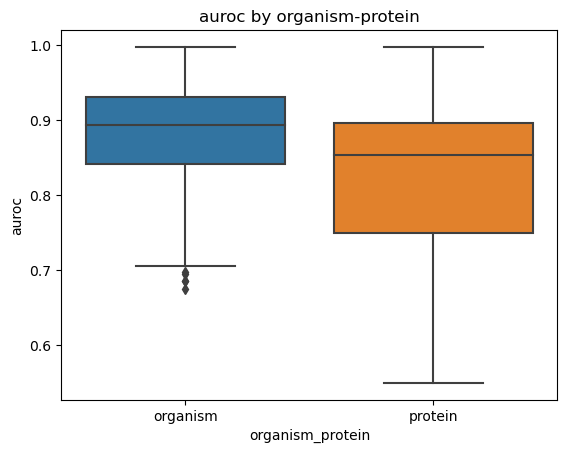

In [33]:
sns.boxplot(data=df_report_model[df_report_model.is_lazy=='lazy'],
            x='organism_protein', y='auroc'
           ).set(title='auroc by organism-protein')

Note: We cannot conclude much from this. The protein models seem less performant, but they also have a much lower amount of data.

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'efaecium'),
  Text(1, 0, 'saureus'),
  Text(2, 0, 'kpneumoniae'),
  Text(3, 0, 'abaumannii'),
  Text(4, 0, 'paeruginosa'),
  Text(5, 0, 'enterobacter')])

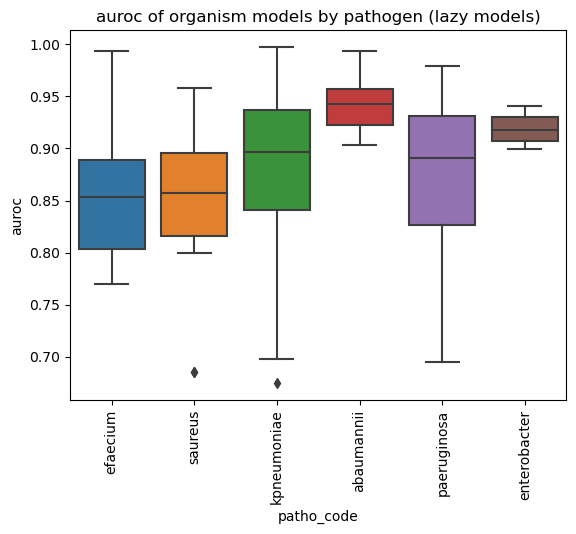

In [34]:
df_model_results_lazy_org = df_model_results[(df_model_results.is_lazy=='lazy') & 
                                             (df_model_results.task_code.str.startswith('organism'))]
sns.boxplot(data=df_model_results_lazy_org, x='patho_code', y='auroc').set(title='auroc of organism models by pathogen (lazy models)')
plt.xticks(rotation = 90)

### Auroc vs size and vs %positives

Text(0.5, 0.98, 'auroc vs train data size')

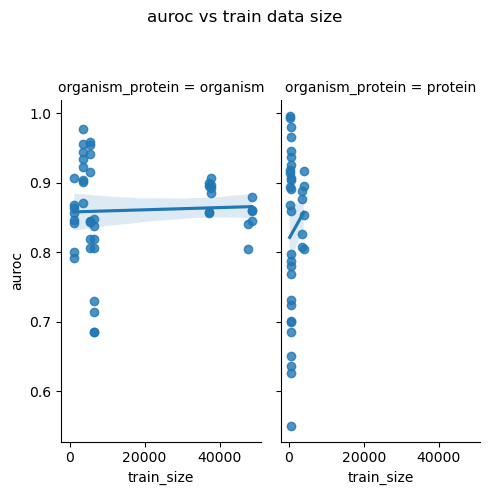

In [35]:
# Auroc vs size - group by organism_protein

g = sns.FacetGrid(df_report_model[df_report_model.patho_code=='saureus'],
                  col="organism_protein", col_order=['organism', 'protein'],
                  height=5, aspect=.5)
g = g.map(sns.regplot, "train_size", "auroc")
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('auroc vs train data size')

Text(0.5, 0.98, 'auroc vs train % positives')

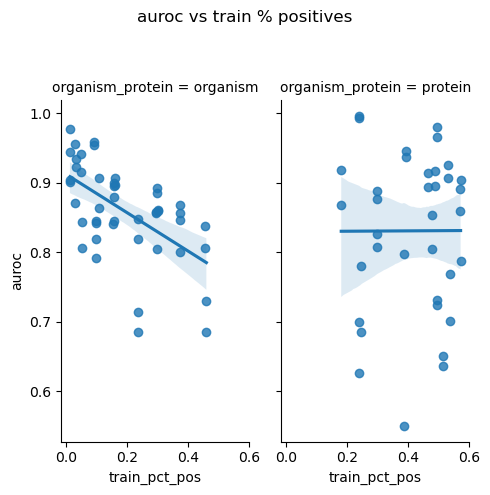

In [39]:
# Auroc vs % positives - group by organism_protein

g = sns.FacetGrid(df_report_model[df_report_model.patho_code=='saureus'],
                  col="organism_protein", col_order=['organism', 'protein'],
                  height=5, aspect=.5)
g = g.map(sns.regplot, "train_pct_pos", "auroc")
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('auroc vs train % positives')

Text(0.5, 0.98, 'AUROC vs similarity test-train1')

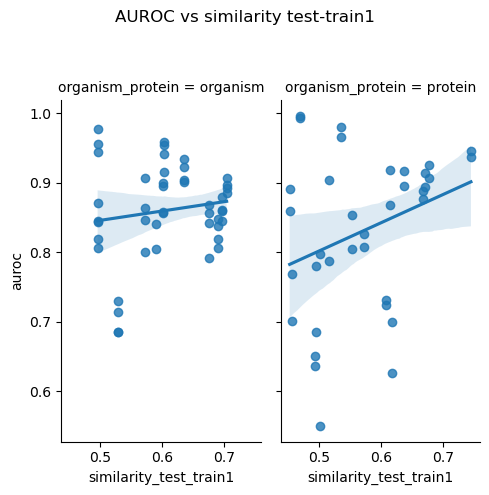

In [40]:
# Auroc vs similarity test-train1 - group by organism_protein

g = sns.FacetGrid(df_report_model[df_report_model.patho_code=='saureus'],
                  col="organism_protein", col_order=['organism', 'protein'],
                  height=5, aspect=.5)
g = g.map(sns.regplot, "similarity_test_train1", "auroc")
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('AUROC vs similarity test-train1')

Text(0.5, 0.98, 'AUROC vs similarity test-train5')

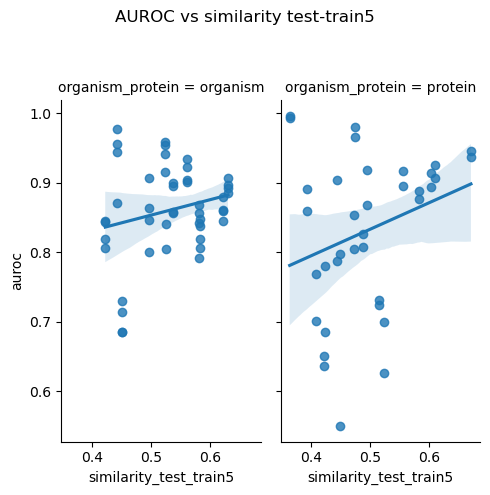

In [41]:
# Auroc vs similarity test-train5 - group by organism_protein

g = sns.FacetGrid(df_report_model[df_report_model.patho_code=='saureus'],
                  col="organism_protein", col_order=['organism', 'protein'],
                  height=5, aspect=.5)
g = g.map(sns.regplot, "similarity_test_train5", "auroc")
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('AUROC vs similarity test-train5')

### Is the ensemble model better than the best submodel? Visualize vs size

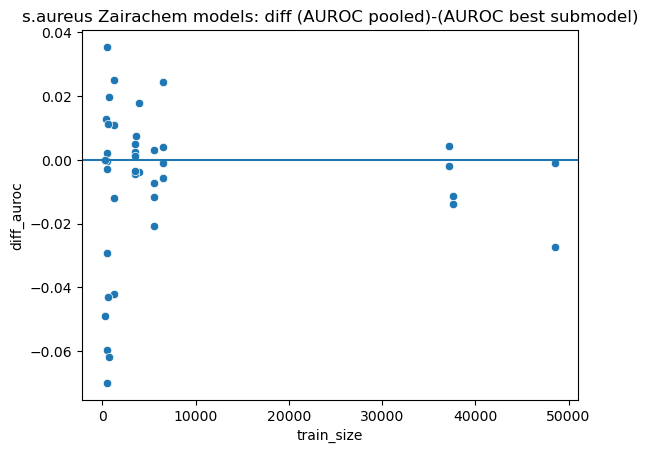

In [42]:
# Improvement of AUROC pooled - auroc best submodel
# Plot vs size
# Only zairachem models

df_temp = df_report_model[df_report_model.is_lazy=='zairachem'].copy()
df_temp['diff_auroc'] = df_temp.auroc - df_temp.best_submodel_auroc
sns.scatterplot(data=df_temp, x='train_size', y='diff_auroc').set(title='s.aureus Zairachem models: diff (AUROC pooled)-(AUROC best submodel)')
plt.axhline(0)


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'fingerprint'),
  Text(1, 0, 'molmap'),
  Text(2, 0, 'individual_full_descriptors-morgan-counts'),
  Text(3, 0, 'individual_full_descriptors-grover-embedding'),
  Text(4, 0, 'individual_full_descriptors-mordred'),
  Text(5, 0, 'classic'),
  Text(6, 0, 'reference_embedding'),
  Text(7, 0, 'manifolds')])

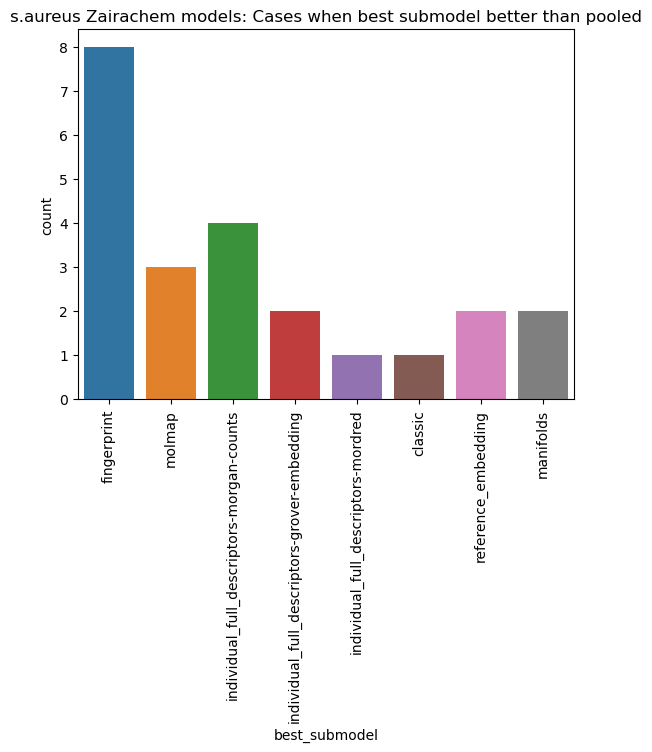

In [43]:
# Which is the best submodel in the cases that it is better than pooled
df_temp = df_report_model[(df_report_model.is_lazy=='zairachem') &
                          (df_report_model.best_submodel_auroc > df_report_model.auroc)].copy()
sns.countplot(data=df_temp, x='best_submodel').set(title='s.aureus Zairachem models: Cases when best submodel better than pooled')
plt.xticks(rotation = 90)